***EDA***

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import powerlaw
from scipy.stats import lognorm
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

In [3]:
messages = pd.read_csv(r"AAPL_2012-06-21_message_10.csv", header=None)
orderbook = pd.read_csv(r"AAPL_2012-06-21_orderbook_10.csv", header=None)

In [4]:
messages.columns = [
    "Time", "Type", "OrderID", "Size", "Price", "Direction"
]

In [5]:
book_cols = []
for level in range(1, 11):
    book_cols += [f"AskPrice{level}", f"AskSize{level}", f"BidPrice{level}", f"BidSize{level}"]
orderbook.columns = book_cols

In [6]:
messages["Time_Readable"] = pd.to_timedelta(messages["Time"], unit='s')

In [7]:
messages["Price"] = messages["Price"] / 10000
for col in orderbook.columns:
    if "Price" in col:
        orderbook[col] = orderbook[col] / 10000

In [8]:
#Mid-Price
orderbook["MidPrice"] = (orderbook["AskPrice1"] + orderbook["BidPrice1"]) / 2

In [9]:
#Spread
orderbook["Spread"] = orderbook["AskPrice1"] - orderbook["BidPrice1"]

In [10]:
#Imbalance
orderbook["Imbalance"] = orderbook["BidSize1"] / (orderbook["BidSize1"] + orderbook["AskSize1"])

In [11]:
features = orderbook[["MidPrice", "Spread", "Imbalance"]]
messages = pd.concat([messages, features], axis=1)

In [12]:
print(messages.head())

           Time  Type   OrderID  Size   Price  Direction  \
0  34200.004241     1  16113575    18  585.33          1   
1  34200.004261     1  16113584    18  585.32          1   
2  34200.004447     1  16113594    18  585.31          1   
3  34200.025552     1  16120456    18  585.91         -1   
4  34200.025580     1  16120480    18  585.92         -1   

              Time_Readable  MidPrice  Spread  Imbalance  
0 0 days 09:30:00.004241176   585.635    0.61   0.082569  
1 0 days 09:30:00.004260640   585.635    0.61   0.082569  
2 0 days 09:30:00.004447484   585.635    0.61   0.082569  
3 0 days 09:30:00.025551909   585.620    0.58   0.500000  
4 0 days 09:30:00.025579546   585.620    0.58   0.500000  


In [14]:
messages_backup = messages.copy()

***Binning***

In [16]:
bin_size = 0.001
messages["TimeBin"] = (messages["Time"] // bin_size).astype(int)

In [17]:
messages = messages[messages["Type"].isin([1, 4, 5])]

In [18]:
messages["IsLO"] = (messages["Type"] == 1).astype(int)
messages["IsMO"] = messages["Type"].isin([4, 5]).astype(int)

In [19]:
# Aggregate binary labels per bin
arrival_df = messages.groupby("TimeBin").agg({
    "IsMO": lambda x: int(x.sum() > 0),
    "IsLO": lambda x: int(x.sum() > 0),
    "MidPrice": "first",  
    "Spread": "first",
    "Imbalance": "first"
}).reset_index()

In [20]:
arrival_df

,TimeBin,IsMO,IsLO,MidPrice,Spread,Imbalance
0,34200004,0,1,585.635,0.61,0.082569
1,34200025,0,1,585.620,0.58,0.500000
2,34200050,0,1,585.620,0.58,0.500000
3,34200201,0,1,585.620,0.58,0.500000
4,34200205,0,1,585.645,0.57,0.152542
...,...,...,...,...,...,...
158581,57599349,0,1,577.610,0.12,0.193717
158582,57599355,1,0,577.610,0.12,0.177936
158583,57599383,0,1,577.635,0.07,0.182301
158584,57599444,1,1,577.635,0.07,0.035370


***Order Arrival Model - Naive-Bernoulli***

In [22]:
p_mo = arrival_df["IsMO"].mean()
p_lo = arrival_df["IsLO"].mean()

In [23]:
arrival_df["SimMO_naive"] = np.random.rand(len(arrival_df)) < p_mo
arrival_df["SimLO_naive"] = np.random.rand(len(arrival_df)) < p_lo

***Order Arrival Model - Logistic-Regression***

In [25]:
from sklearn.linear_model import LogisticRegression

features = arrival_df[["Spread", "Imbalance"]].fillna(0)
X = features.values
y_mo = arrival_df["IsMO"]
y_lo = arrival_df["IsLO"]

logit_mo = LogisticRegression().fit(X, y_mo)
logit_lo = LogisticRegression().fit(X, y_lo)

# Predict probabilities
arrival_df["p_MO"] = logit_mo.predict_proba(X)[:, 1]
arrival_df["p_LO"] = logit_lo.predict_proba(X)[:, 1]

# Add noise to MO probabilities
arrival_df["p_MO_noisy"] = arrival_df["p_MO"] + np.random.normal(0, 0.02, size=len(arrival_df))
arrival_df["p_MO_noisy"] = arrival_df["p_MO_noisy"].clip(0, 1)


In [26]:
def sample_arrival(p):
    return np.random.rand() < p

arrival_df["SimMO_logistic_regression"] = arrival_df["p_MO_noisy"].apply(sample_arrival)

arrival_df["SimLO_logistic_regression"] = arrival_df["p_LO"].apply(sample_arrival)

In [27]:
arrival_df

,TimeBin,IsMO,IsLO,MidPrice,Spread,Imbalance,SimMO_naive,SimLO_naive,p_MO,p_LO,p_MO_noisy,SimMO_logistic_regression,SimLO_logistic_regression
0,34200004,0,1,585.635,0.61,0.082569,False,True,0.007144,0.997574,0.004258,False,True
1,34200025,0,1,585.620,0.58,0.500000,False,True,0.008463,0.996969,0.020292,False,True
2,34200050,0,1,585.620,0.58,0.500000,False,True,0.008463,0.996969,0.000705,False,True
3,34200201,0,1,585.620,0.58,0.500000,False,True,0.008463,0.996969,0.020146,False,True
4,34200205,0,1,585.645,0.57,0.152542,False,True,0.009183,0.996803,0.008256,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158581,57599349,0,1,577.610,0.12,0.193717,False,True,0.142581,0.934713,0.136730,False,True
158582,57599355,1,0,577.610,0.12,0.177936,False,True,0.142682,0.934755,0.128781,False,True
158583,57599383,0,1,577.635,0.07,0.182301,True,True,0.186581,0.910505,0.208787,False,True
158584,57599444,1,1,577.635,0.07,0.035370,False,True,0.187748,0.911027,0.184569,False,True


***Model Side and Size - Power Law***

In [29]:
mo = messages[messages["IsMO"] == 1].copy()
lo = messages[messages["IsLO"] == 1].copy()

# Time-dependent probabilities
p_buy_mo_by_bin = mo.groupby("TimeBin")["Direction"].apply(lambda x: (x == 1).mean())
p_buy_lo_by_bin = lo.groupby("TimeBin")["Direction"].apply(lambda x: (x == 1).mean())



In [30]:
# Fit exponential distributions to order sizes
from scipy.stats import expon
from scipy.stats import powerlaw

# Split into 4 groups
sizes = {
    "buy_mo": mo[mo["Direction"] == 1]["Size"],
    "sell_mo": mo[mo["Direction"] == -1]["Size"],
    "buy_lo": lo[lo["Direction"] == 1]["Size"],
    "sell_lo": lo[lo["Direction"] == -1]["Size"]
}

# Fit exponentials
size_params = {k: powerlaw.fit(v, floc=0) for k, v in sizes.items()}  # force loc=0

In [31]:
def sample_size(order_type, direction):
    key = f"{'buy' if direction == 1 else 'sell'}_{order_type}"
    a, loc, scale = size_params[key]
    sampled_size = powerlaw.rvs(a, loc=loc, scale=scale)
    rounded_size = int(np.round(sampled_size / 100.0) * 100)
    return max(100, rounded_size)

***Limit Order Price DIstance From Mid-Price***

In [36]:
lo["Distance"] = np.abs(lo["Price"] - lo["MidPrice"])
from scipy.stats import lognorm
dist_param = lognorm.fit(lo["Distance"], floc=0)

def sample_distance():
    return lognorm.rvs(*dist_param)

def sample_limit_price(mid_price, direction):
    delta = sample_distance()
    return mid_price + delta if direction == 1 else mid_price - delta


***Model Mid-Price Movement (Random Walk)***

In [38]:
# Multiplicative returns
arrival_df["MidPriceNext"] = arrival_df["MidPrice"].shift(-1)
returns = (arrival_df["MidPriceNext"] / arrival_df["MidPrice"]).dropna()

# Fit lognormal to multiplicative returns
ret_param = lognorm.fit(returns, floc=0)

# Function to simulate mid-price path using the fitted model
def simulate_mid_prices(P0, steps):
    prices = [P0]
    for _ in range(steps):
        R = lognorm.rvs(*ret_param)  # R = multiplicative return
        prices.append(prices[-1] * R)
    return prices

***Autocorrelation Analysis***

<Figure size 1000x400 with 0 Axes>

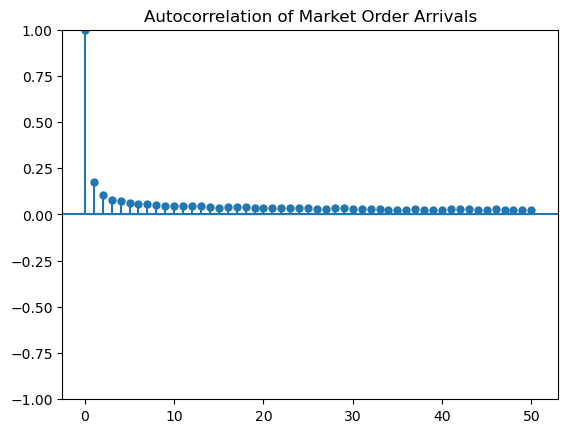

In [40]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# ACF for order arrival
plt.figure(figsize=(10,4))
plot_acf(arrival_df["IsMO"], lags=50)
plt.title("Autocorrelation of Market Order Arrivals")
plt.show()


***Generate Synthetic Orders***

In [42]:
from scipy.stats import lognorm
import numpy as np

def simulate_lo_price(mid_price, dist_params, direction):
    offset = lognorm.rvs(*dist_params)
    offset = min(offset, 0.5)  # truncate
    raw_price = mid_price + offset if direction == 1 else mid_price - offset
    tick_size = 0.01
    return round(raw_price / tick_size) * tick_size



# Fit LO distance distribution from real data
lo_price_dist_param = lognorm.fit(lo["Distance"], floc=0)

synthetic_orders = []

# Simulate mid-price path
sim_mid_prices = simulate_mid_prices(P0=arrival_df["MidPrice"].iloc[0], steps=len(arrival_df))

# Get discrete spread values and their frequencies
spread_counts = messages["Spread"].round(2).value_counts(normalize=True)
spread_values = spread_counts.index.to_numpy()
spread_probs = spread_counts.values

# Sample synthetic spreads from real distribution
sim_spreads = np.random.choice(spread_values, size=len(arrival_df), p=spread_probs)


# Main simulation loop
for idx, row in arrival_df.iterrows():
    time_bin = row["TimeBin"]
    mid_price = sim_mid_prices[idx]
    spread = sim_spreads[idx]

    p_buy = p_buy_mo_by_bin.get(time_bin, 0.5)
    buy_or_sell = np.random.rand() < p_buy
    side = 1 if buy_or_sell else -1

    # Market Order
    if row["SimMO_logistic_regression"]:
        p_buy = p_buy_mo_by_bin.get(time_bin, 0.5)
        side = 1 if np.random.rand() < p_buy else -1

        size = sample_size("mo", direction=side)

        synthetic_orders.append({
            "Type": "MO",
            "Side": side,
            "Size": size,
            "Price": mid_price,  # MOs hit top of book
            "TimeBin": time_bin,
            "MidPrice": mid_price,
            "Spread": spread,
        })

    # Limit Order
    if row["SimLO_logistic_regression"]:
        p_buy = p_buy_lo_by_bin.get(time_bin, 0.5)
        side = 1 if np.random.rand() < p_buy else -1

        size = sample_size("lo", direction=side)

        price = simulate_lo_price(mid_price, lo_price_dist_param, direction=side)
        synthetic_orders.append({
            "Type": "LO",
            "Side": side,
            "Size": size,
            "Price": price,
            "TimeBin": time_bin,
            "MidPrice": mid_price,
            "Spread": spread,
        })

In [43]:
synthetic_df = pd.DataFrame(synthetic_orders)
synthetic_df.to_csv("synthetic_orders.csv", index=False)

In [44]:
lo_df = synthetic_df[synthetic_df["Type"] == "LO"]

book_stats = lo_df.groupby("TimeBin").apply(
    lambda df: pd.Series({
        "BidSize": df[df["Side"] == 1]["Size"].sum(),
        "AskSize": df[df["Side"] == -1]["Size"].sum()
    })
).dropna()

book_stats["Imbalance"] = book_stats["BidSize"] / (book_stats["BidSize"] + book_stats["AskSize"])


# Replace unrealistic imbalance with samples from real distribution
real_imbalances = messages["Imbalance"].dropna().values
imbalance_counts = pd.Series(real_imbalances).value_counts(normalize=True)
values = imbalance_counts.index.to_numpy()
probs = imbalance_counts.values
synthetic_df["Imbalance"] = np.random.choice(values, size=len(synthetic_df), p=probs)

C:\Users\tomas\AppData\Local\Temp\ipykernel_4944\2099668336.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  book_stats = lo_df.groupby("TimeBin").apply(


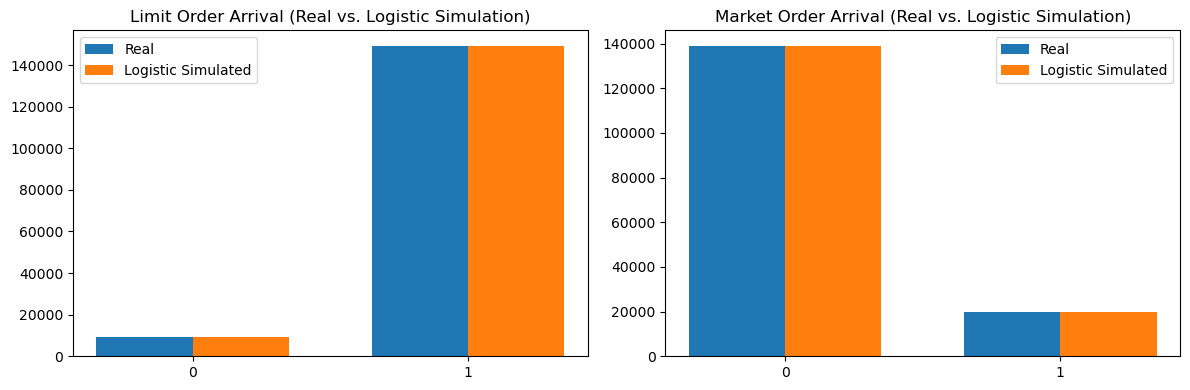

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bins = [0, 1]
width = 0.35

# Limit order arrival comparison
axs[0].bar([b - width/2 for b in bins], arrival_df["IsLO"].value_counts().sort_index(), 
           width=width, label="Real", align='center')
axs[0].bar([b + width/2 for b in bins], arrival_df["SimLO_logistic_regression"].value_counts().sort_index(), 
           width=width, label="Logistic Simulated", align='center')
axs[0].set_title("Limit Order Arrival (Real vs. Logistic Simulation)")
axs[0].set_xticks([0, 1])
axs[0].legend()

# Market order arrival comparison
axs[1].bar([b - width/2 for b in bins], arrival_df["IsMO"].value_counts().sort_index(), 
           width=width, label="Real", align='center')
axs[1].bar([b + width/2 for b in bins], arrival_df["SimMO_logistic_regression"].value_counts().sort_index(), 
           width=width, label="Logistic Simulated", align='center')
axs[1].set_title("Market Order Arrival (Real vs. Logistic Simulation)")
axs[1].set_xticks([0, 1])
axs[1].legend()

plt.tight_layout()
plt.show()

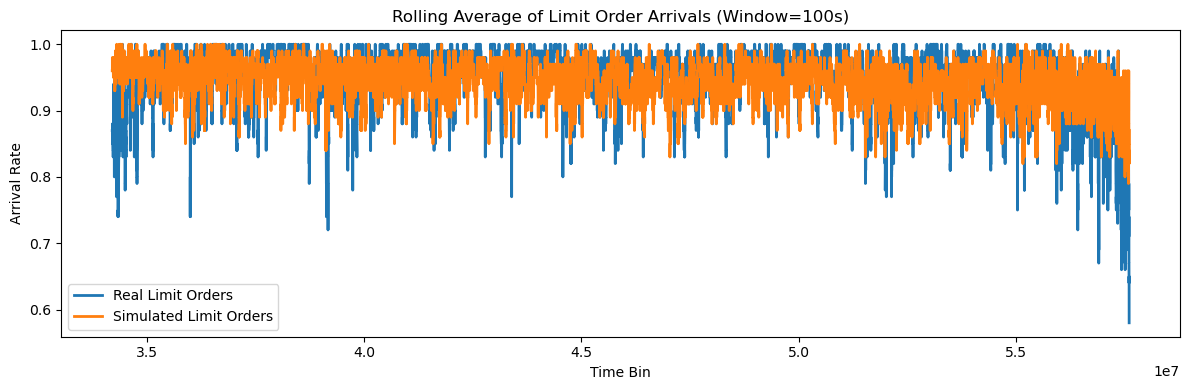

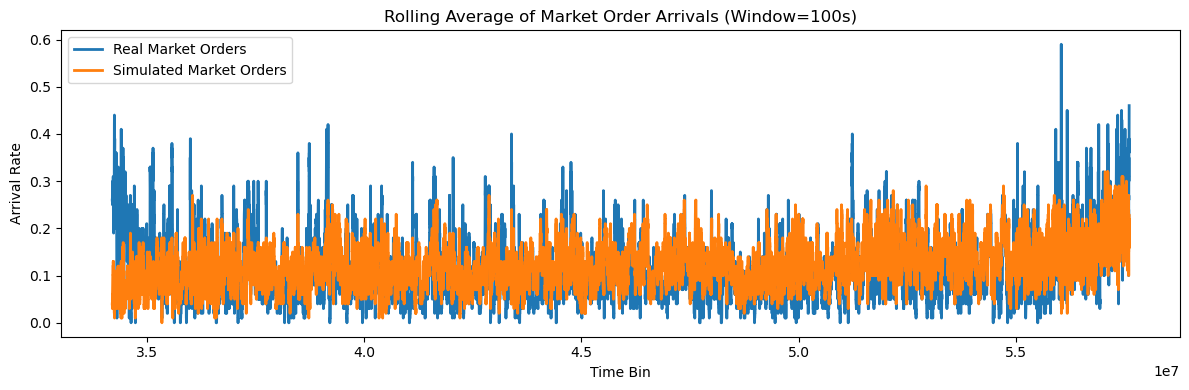

In [49]:
import matplotlib.pyplot as plt

window = 100
arrival_df["SimLO_logistic_regression"] = arrival_df["SimLO_logistic_regression"].astype(int)
arrival_df["SimMO_logistic_regression"] = arrival_df["SimMO_logistic_regression"].astype(int)

# Limit Orders
plt.figure(figsize=(12, 4))
plt.plot(arrival_df["TimeBin"], arrival_df["IsLO"].rolling(window).mean(), label="Real Limit Orders", linewidth=2)
plt.plot(arrival_df["TimeBin"], arrival_df["SimLO_logistic_regression"].rolling(window).mean(), label="Simulated Limit Orders", linewidth=2)
plt.title(f"Rolling Average of Limit Order Arrivals (Window={window}s)")
plt.xlabel("Time Bin")
plt.ylabel("Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Market Orders
plt.figure(figsize=(12, 4))
plt.plot(arrival_df["TimeBin"], arrival_df["IsMO"].rolling(window).mean(), label="Real Market Orders", linewidth=2)
plt.plot(arrival_df["TimeBin"], arrival_df["SimMO_logistic_regression"].rolling(window).mean(), label="Simulated Market Orders", linewidth=2)
plt.title(f"Rolling Average of Market Order Arrivals (Window={window}s)")
plt.xlabel("Time Bin")
plt.ylabel("Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
messages = messages_backup.copy()

In [62]:
# Keep only limit orders and executions (market orders)
messages = messages[messages["Type"].isin([1, 4, 5])].copy()

# Reset index if needed
messages.reset_index(drop=True, inplace=True)

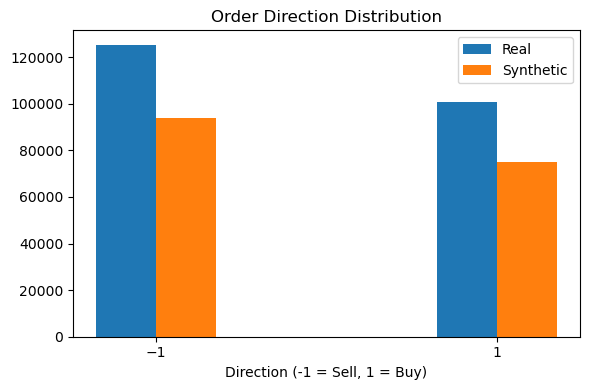

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
real_dir = messages['Direction'].value_counts().sort_index()
synth_dir = synthetic_df['Side'].value_counts().sort_index()

bar_width = 0.35
ax.bar([-1 - bar_width/2, 1 - bar_width/2], real_dir, width=bar_width, label='Real')
ax.bar([-1 + bar_width/2, 1 + bar_width/2], synth_dir, width=bar_width, label='Synthetic')
ax.set_xticks([-1, 1])
ax.set_title("Order Direction Distribution")
ax.set_xlabel("Direction (-1 = Sell, 1 = Buy)")
ax.legend()
plt.tight_layout()
plt.show()

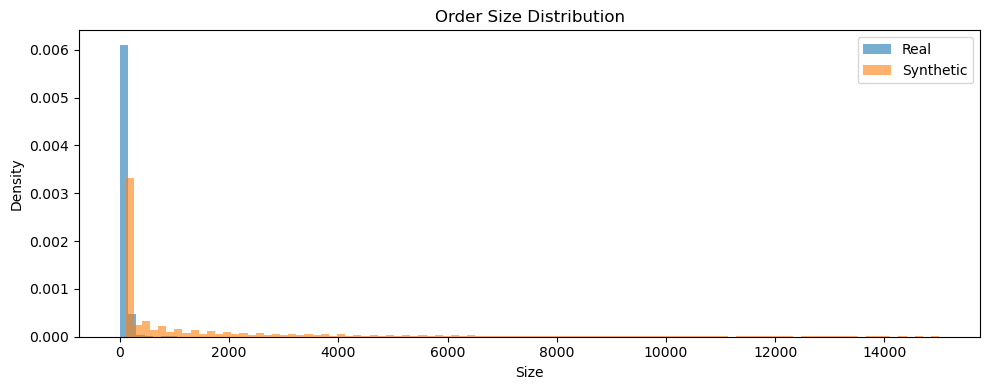

In [64]:
plt.figure(figsize=(10, 4))

plt.hist(messages['Size'], bins=100, alpha=0.6, label='Real', density=True)
plt.hist(synthetic_df['Size'], bins=100, alpha=0.6, label='Synthetic', density=True)
plt.title("Order Size Distribution")
plt.xlabel("Size")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

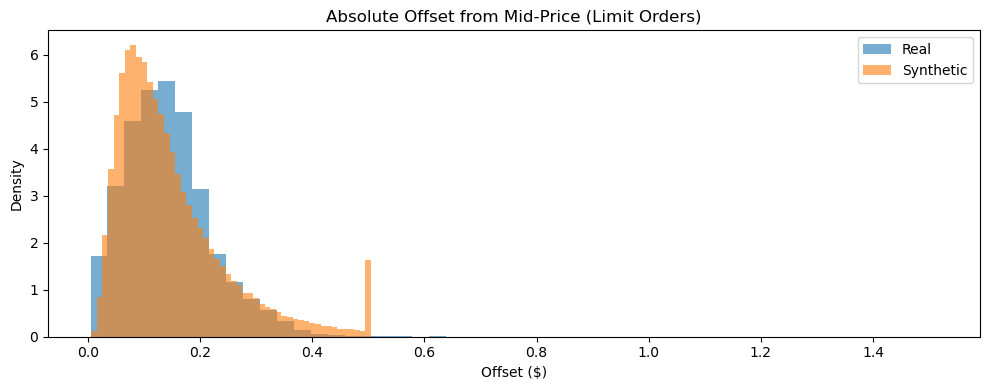

In [65]:
import matplotlib.pyplot as plt

# Compute offset from mid-price
real_limit = messages[messages["Type"] == 1].copy()
real_limit["abs_offset"] = abs(real_limit["Price"] - real_limit["MidPrice"])

synth_limit = synthetic_df[synthetic_df["Type"] == "LO"].copy()
synth_limit["abs_offset"] = abs(synth_limit["Price"] - synth_limit["MidPrice"])

# Drop NaNs just in case
real_offset = real_limit["abs_offset"].dropna()
synth_offset = synth_limit["abs_offset"].dropna()

plt.figure(figsize=(10, 4))
plt.hist(real_offset, bins=50, alpha=0.6, label='Real', density=True)
plt.hist(synth_offset, bins=50, alpha=0.6, label='Synthetic', density=True)
plt.title("Absolute Offset from Mid-Price (Limit Orders)")
plt.xlabel("Offset ($)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
BIN_SIZE = 0.001
messages["TimeBin"] = (messages["Time"] // BIN_SIZE).astype(int)  # or messages["Time"] * 1000

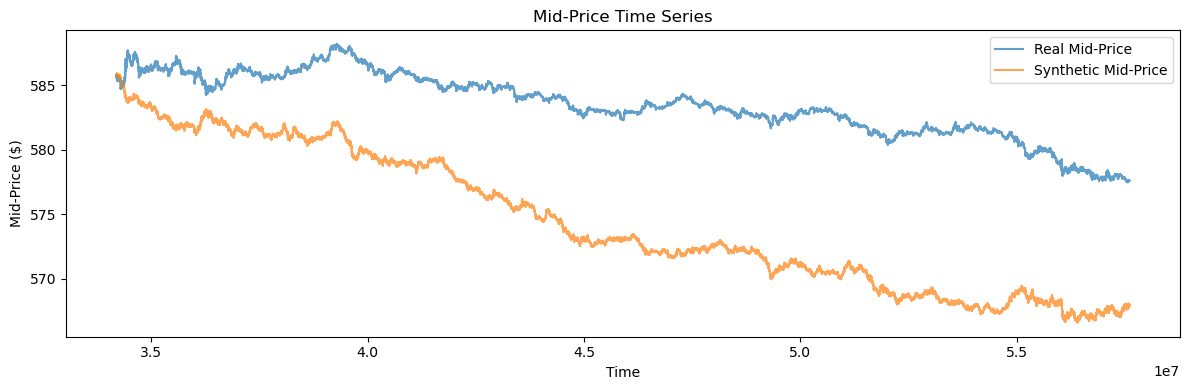

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(messages['TimeBin'], messages['MidPrice'], label='Real Mid-Price', alpha=0.7)
plt.plot(synthetic_df['TimeBin'], synthetic_df['MidPrice'], label='Synthetic Mid-Price', alpha=0.7)
plt.title("Mid-Price Time Series")
plt.xlabel("Time")
plt.ylabel("Mid-Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

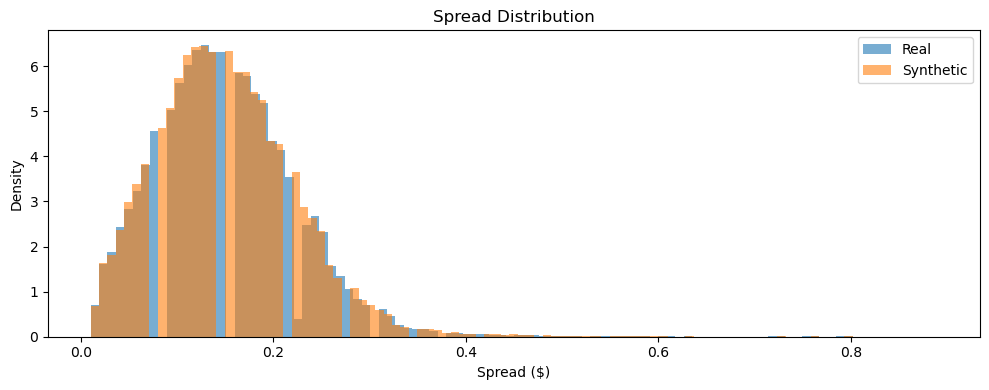

In [68]:
plt.figure(figsize=(10, 4))
plt.hist(messages['Spread'], bins=100, alpha=0.6, label='Real', density=True)
plt.hist(synthetic_df['Spread'], bins=100, alpha=0.6, label='Synthetic', density=True)
plt.title("Spread Distribution")
plt.xlabel("Spread ($)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

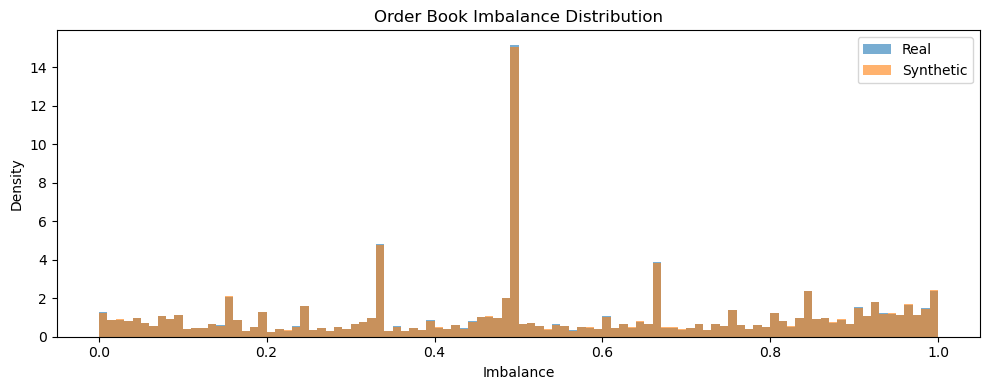

In [69]:
plt.figure(figsize=(10, 4))
plt.hist(messages['Imbalance'], bins=100, alpha=0.6, label='Real', density=True)
plt.hist(synthetic_df['Imbalance'], bins=100, alpha=0.6, label='Synthetic', density=True)
plt.title("Order Book Imbalance Distribution")
plt.xlabel("Imbalance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
messages["Imbalance"].describe()

count    226005.000000
mean          0.533659
std           0.284333
min           0.000337
25%           0.333333
50%           0.500000
75%           0.793651
max           0.999757
Name: Imbalance, dtype: float64

In [71]:
synthetic_df

,Type,Side,Size,Price,TimeBin,MidPrice,Spread,Imbalance
0,LO,1,800,585.810000,34200004,585.635000,0.18,0.400000
1,LO,-1,3800,585.560000,34200025,585.636436,0.17,0.141443
2,LO,1,100,585.670000,34200050,585.648600,0.25,0.990099
3,LO,1,2000,585.700000,34200201,585.643729,0.20,0.056604
4,LO,1,1600,585.860000,34200205,585.655385,0.12,0.995025
...,...,...,...,...,...,...,...,...
168854,LO,1,700,568.090000,57599355,567.912551,0.06,0.082569
168855,LO,1,200,568.080000,57599383,567.917383,0.19,0.764706
168856,LO,-1,200,567.860000,57599444,567.927815,0.21,0.178571
168857,MO,-1,400,567.930027,57599913,567.930027,0.03,0.500000


In [72]:
synthetic_df = synthetic_df.rename(columns={
    'Side': 'Direction',
    'TimeBin': 'Time'
})

# Add OrderID (if not already present)
synthetic_df['OrderID'] = np.arange(1, len(synthetic_df) + 1)

# Reorder columns to match the expected format
synthetic_df = synthetic_df[['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']]

synthetic_df['Type'] = synthetic_df['Type'].map({'MO': 'Market', 'LO': 'Limit'})


In [73]:
synthetic_df

,Time,Type,OrderID,Size,Price,Direction
0,34200004,Limit,1,800,585.810000,1
1,34200025,Limit,2,3800,585.560000,-1
2,34200050,Limit,3,100,585.670000,1
3,34200201,Limit,4,2000,585.700000,1
4,34200205,Limit,5,1600,585.860000,1
...,...,...,...,...,...,...
168854,57599355,Limit,168855,700,568.090000,1
168855,57599383,Limit,168856,200,568.080000,1
168856,57599444,Limit,168857,200,567.860000,-1
168857,57599913,Market,168858,400,567.930027,-1


In [74]:
synthetic_df['Time'] = synthetic_df['Time'].astype(float)
synthetic_df['Size'] = synthetic_df['Size'].astype(int)
synthetic_df['Price'] = synthetic_df['Price'].astype(float)
synthetic_df['Direction'] = synthetic_df['Direction'].astype(int)
synthetic_df['OrderID'] = synthetic_df['OrderID'].astype(int)

In [75]:
synthetic_df.to_csv("synthetic_message_file.csv", index=False)

AUC for Market Order Model: 0.6262
AUC for Limit Order Model: 0.6343


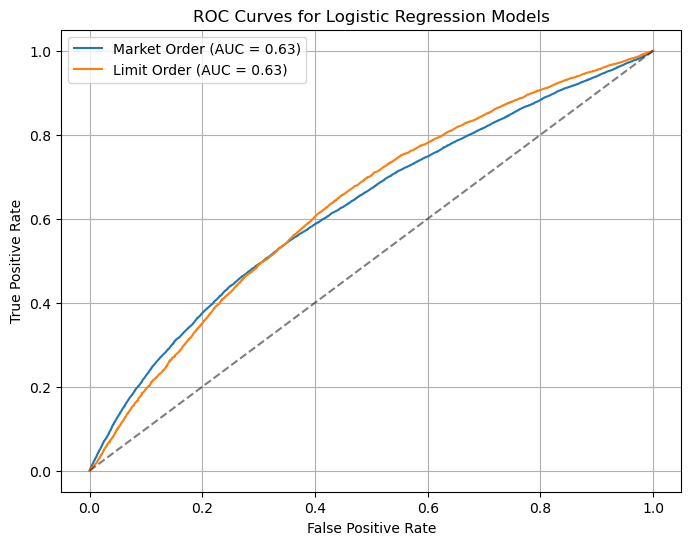

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# AUC scores
auc_mo = roc_auc_score(y_mo, arrival_df["p_MO"])
auc_lo = roc_auc_score(y_lo, arrival_df["p_LO"])

print(f"AUC for Market Order Model: {auc_mo:.4f}")
print(f"AUC for Limit Order Model: {auc_lo:.4f}")

# ROC Curves
fpr_mo, tpr_mo, _ = roc_curve(y_mo, arrival_df["p_MO"])
fpr_lo, tpr_lo, _ = roc_curve(y_lo, arrival_df["p_LO"])

plt.figure(figsize=(8, 6))
plt.plot(fpr_mo, tpr_mo, label=f"Market Order (AUC = {auc_mo:.2f})")
plt.plot(fpr_lo, tpr_lo, label=f"Limit Order (AUC = {auc_lo:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic Regression Models")
plt.legend()
plt.grid(True)
plt.show()